In [ ]:
! pip install -q kaggle

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aarav20","key":"121784cd4910f61cb309ca77250bf290"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [01:02<00:00, 118MB/s]
100% 5.30G/5.30G [01:02<00:00, 91.4MB/s]


In [ ]:
!unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
META_PATH = "meta/meta/"
IMG_FILE_PATH = "images/"

classes = pd.read_csv(META_PATH+'classes.txt', header=None)
labels = pd.read_csv(META_PATH+'labels.txt', header=None)
class_to_norminal = dict(zip(classes[0].values, range(classes.shape[0])))

train_df = pd.read_csv(META_PATH+'train.txt', names=['txt'], header=None)
train_df['img'] = train_df['txt'].apply(lambda x : x+'.jpg')
train_df['label'] = train_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

train_df.drop(['txt'], axis=1, inplace=True)
train_df = train_df.sample(frac=1)
valid_df = pd.read_csv(META_PATH+'test.txt', names=['txt'], header=None)
valid_df['img'] = valid_df['txt'].apply(lambda x: x+'.jpg')
valid_df['label'] = valid_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

valid_df.drop(['txt'], axis=1, inplace=True)
valid_df = valid_df.sample(frac=1)

print(f'train_data: {train_df.shape}')
print(f'valid_data: {valid_df.shape}')

train_data: (75750, 2)
valid_data: (25250, 2)


In [ ]:
train_dg = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)

valid_dg = ImageDataGenerator(
        rescale=1./255,
)

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 224

train_data = train_dg.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)
valid_data = valid_dg.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)

Found 75750 validated image filenames.
Found 25250 validated image filenames.


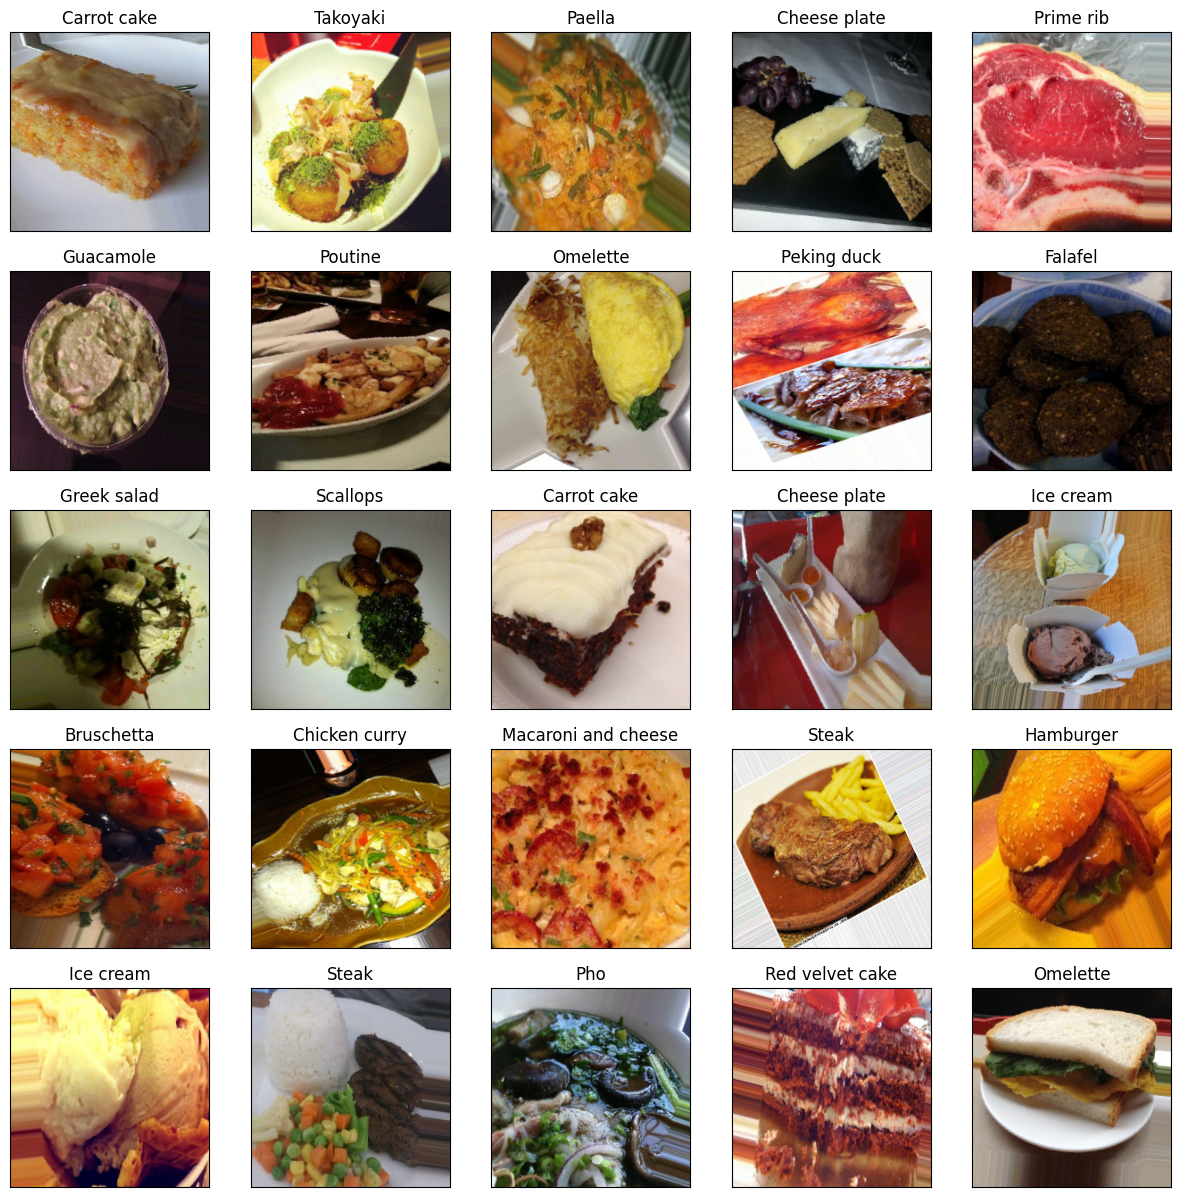

In [ ]:
x, y = next(train_data)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x[i+j*5])
        ax[i][j].set_title(labels[0][y[i+j*5]])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

In [ ]:
# load pretrained model
pre_trained = keras.applications.MobileNetV3Large(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
pre_trained.trainable = True

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
#Build The Model
model = keras.Sequential([
    pre_trained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               13029     
                                                                 
Total params: 3,132,389
Trainable params: 3,107,989
Non-

In [ ]:
EPOCHS=8

# callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
chkp = keras.callbacks.ModelCheckpoint('mobilenet_v3_large_checkpoint.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

with tf.device('/GPU:0'):
    hist = model.fit(
        train_data,
        validation_data = valid_data,
        epochs = EPOCHS,
        callbacks=[early_stop, reduce_lr, chkp],
    )
model.save('mobilenet_v3_large_final.h5')

Epoch 1/8
1184/1184 [==============================] - ETA: 0s - loss: 2.9545 - accuracy: 0.3146
Epoch 1: val_accuracy improved from -inf to 0.00994, saving model to mobilenet_v3_large_checkpoint.h5
1184/1184 [==============================] - 1563s 1s/step - loss: 2.9545 - accuracy: 0.3146 - val_loss: 33.1061 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 2/8
1184/1184 [==============================] - ETA: 0s - loss: 1.8564 - accuracy: 0.5468
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.00994
1184/1184 [==============================] - 1500s 1s/step - loss: 1.8564 - accuracy: 0.5468 - val_loss: 1193.4669 - val_accuracy: 0.0083 - lr: 0.0010
Epoch 3/8
1184/1184 [==============================] - ETA: 0s - loss: 1.3402 - accuracy: 0.6658
Epoch 3: val_accuracy improved from 0.00994 to 0.01212, saving model to mobilenet_v3_large_checkpoint.h5
1184/1184 [==============================] - 1447s 1s/step - loss: 1.3402

In [ ]:
# Training Accuracy is 76.4%

# Validation Accuracy is 78.7%